In [476]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
#Data from table
T=1/12

X_strikes = np.array([1.0681,1.0791,1.0904,1.1014,1.1119])
X_market_vols = np.array([0.0554,0.053115,0.0516,0.051435,0.0523])
X_market_vars = X_market_vols**2 * T
X_forw=1.0903
X_strikes_lognrm = np.log(X_strikes / X_forw)

Y_strikes = np.array([1.2456,1.2595,1.274,1.2883,1.3017])
Y_market_vols = np.array([0.06055,0.058665,0.0573,0.057185,0.05765])
Y_market_vars = Y_market_vols**2 * T
Y_forw=1.2738
Y_strikes_lognrm = np.log(Y_strikes / Y_forw)

Z_strikes = np.array([0.84386,0.84969,0.85585,0.86234,0.86875])
Z_market_vols = np.array([0.03809,0.03725,0.037225,0.03825,0.03986])
Z_market_vars = Z_market_vols**2 * T
Z_forw=0.8559
Z_strikes_lognrm = np.log(Z_strikes / Z_forw)

In [477]:
def svi_var(k_lognrm,params):
    """
    k: array of strikes (log-normalised)
    a: base level of volatility
    b: slope
    sigma: curvature
    rho: skewness
    m: location of minimum volatility
    """
    a, b, sigma, rho, m = params[0], params[1], params[2], params[3], params[4]
    rho=min(max(rho,-1.0),1.0)
    b=min(b,2/(1+np.abs(rho)))
    a=max(a,-b*sigma*np.sqrt(1-rho**2))
    x=k_lognrm
    return a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))

def svi_vol(k_lognrm,params,T):
    return np.sqrt(svi_var(k_lognrm,params)/T)

In [478]:
def svi_rss(k_lognrm,params,obs_v):
    return np.sum((svi_vol(k_lognrm,params,T)-obs_v)**2)

In [499]:
def svi_fit(k_lognrm,obs_vars,bestp):
    #input strikes and market vols, return params for SVI smile
    
    params_init = bestp  # initial guess for [a, b, sigma, rho, m] {"a": 0.05125, "b": 0.09, "rho": -0.3, "m": 1.0975, "sigma": 0.001}
    
    def objective(params):
        return svi_rss(k_lognrm,params,obs_vars)
    
    result = minimize(
        fun=objective, 
        x0=params_init,
        method='Nelder-Mead', 
        tol=1E-14, 
        options={"maxiter":2000}
    )
    
    return result

In [500]:
Xopt = svi_fit(X_strikes_lognrm,X_market_vols,bestpX)
opt_params_X = Xopt.x
print("EUR/USD Optimised?:", Xopt.success)
print("X Parameters:")
print("a =", Xopt.x[0])
print("b =", Xopt.x[1])
print("sigma =", Xopt.x[2])
print("rho =", Xopt.x[3])
print("m =", Xopt.x[4])
print("Initial guess:", bestpX)
print("RSS error:", Xopt.fun)

EUR/USD Optimised?: True
X Parameters:
a = 0.00017395967716872946
b = 0.002357342666180569
sigma = 0.019751728637618392
rho = -0.19195814355040003
m = 0.0023963181452868803
Initial guess: [0.0001, 0.002, 0.0014, 0, 0.005]
RSS error: 1.4444474582904269e-34


In [501]:
Yopt = svi_fit(Y_strikes_lognrm,Y_market_vols,bestpX)
opt_params_Y = Yopt.x
print("GBP/USD Optimised?:", Yopt.success)
print("Y Parameters:")
print("a =", Yopt.x[0])
print("b =", Yopt.x[1])
print("sigma =", Yopt.x[2])
print("rho =", Yopt.x[3])
print("m =", Yopt.x[4])
print("RSS error:", Yopt.fun)

GBP/USD Optimised?: True
Y Parameters:
a = 0.00025809251367852487
b = 0.0013137615981889616
sigma = -0.011821269412605364
rho = -0.47384834704562945
m = 0.0001322965184369659
RSS error: 0.0


In [502]:
Zopt = svi_fit(Z_strikes_lognrm,Z_market_vols,[0.00001, 0.002, 0.0014, 0, 0.005])
opt_params_Z = Zopt.x
print("EUR/GBP Optimised?:", Zopt.success)
print("Z Parameters:")
print("a =", Zopt.x[0])
print("b =", Zopt.x[1])
print("sigma =", Zopt.x[2])
print("rho =", Zopt.x[3])
print("m =", Zopt.x[4])
print("RSS error:", Zopt.fun)

EUR/GBP Optimised?: True
Z Parameters:
a = 8.894822952947739e-05
b = 0.0018317572059449935
sigma = -0.01413702885396971
rho = 0.09302238165324989
m = -0.002133861365615514
RSS error: 0.0


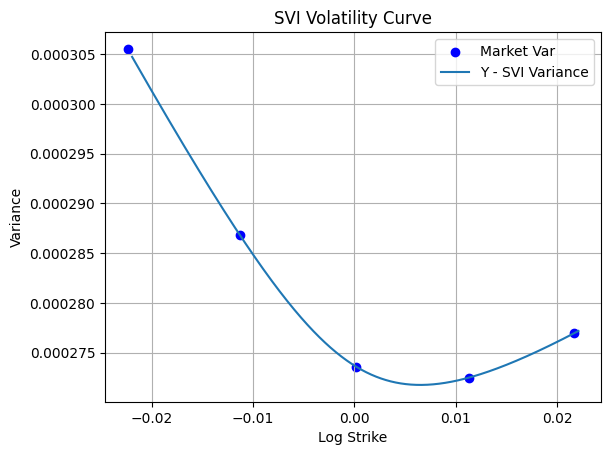

In [503]:
strike_ax = np.linspace(0.98*min(Y_strikes_lognrm), 1.02*max(Y_strikes_lognrm), 1000)  # Match the range of market data
var_ax= svi_var(strike_ax,opt_params_Y)

plt.scatter(Y_strikes_lognrm, Y_market_vars, label='Market Var', color='blue')
plt.plot(strike_ax, var_ax, label='Y - SVI Variance')
plt.xlabel('Log Strike')
plt.ylabel('Variance')
plt.title('SVI Volatility Curve')
plt.legend()
plt.grid()  

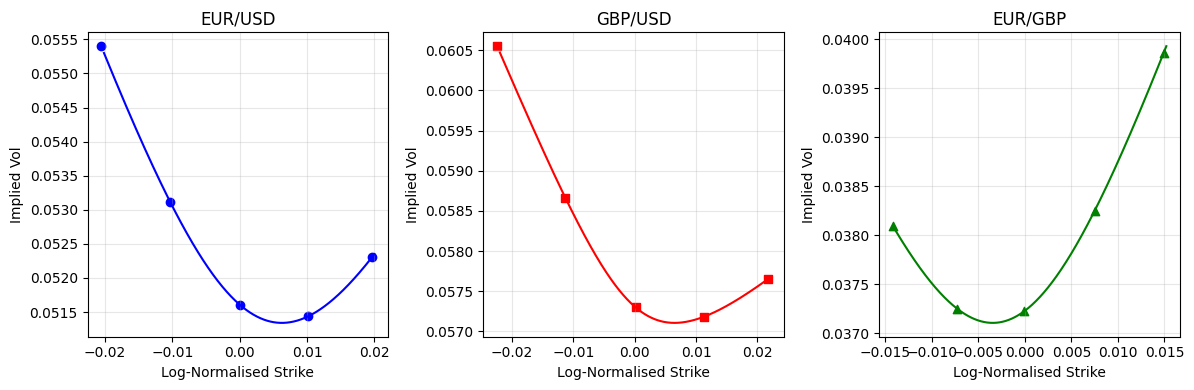

In [504]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))


X_strike_range = np.linspace(0.98*min(X_strikes_lognrm), 1.02*max(X_strikes_lognrm), 1000)
Y_strike_range = np.linspace(0.98*min(Y_strikes_lognrm), 1.02*max(Y_strikes_lognrm), 1000)
Z_strike_range = np.linspace(0.98*min(Z_strikes_lognrm), 1.02*max(Z_strikes_lognrm), 1000)


ax1.scatter(X_strikes_lognrm, X_market_vols, label='Market Data', color='blue', marker='o')
ax1.plot(X_strike_range, svi_vol(X_strike_range, Xopt.x,T), 'b-', label='SVI Fit')
ax1.set_title('EUR/USD')
ax1.set_ylabel('Implied Vol')
ax1.set_xlabel('Log-Normalised Strike')
ax1.grid(True, alpha=0.3)


ax2.scatter(Y_strikes_lognrm, Y_market_vols, label='Market Data', color='red', marker='s')
ax2.plot(Y_strike_range, svi_vol(Y_strike_range, Yopt.x,T), 'r-', label='SVI Fit')
ax2.set_title('GBP/USD')
ax2.set_xlabel('Log-Normalised Strike')
ax2.set_ylabel('Implied Vol')
ax2.grid(True, alpha=0.3)


ax3.scatter(Z_strikes_lognrm, Z_market_vols, label='Market Data', color='green', marker='^')
ax3.plot(Z_strike_range, svi_vol(Z_strike_range, Zopt.x,T), 'g-', label='SVI Fit')
ax3.set_title('EUR/GBP')
ax3.set_xlabel('Log-Normalised Strike')
ax3.set_ylabel('Implied Vol')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [505]:
print("SVI Parameters for EUR/USD:", opt_params_X)
print("SVI Parameters for GBP/USD:", opt_params_Y)
print("SVI Parameters for EUR/GBP:", opt_params_Z)

SVI Parameters for EUR/USD: [ 1.73959677e-04  2.35734267e-03  1.97517286e-02 -1.91958144e-01
  2.39631815e-03]
SVI Parameters for GBP/USD: [ 2.58092514e-04  1.31376160e-03 -1.18212694e-02 -4.73848347e-01
  1.32296518e-04]
SVI Parameters for EUR/GBP: [ 8.89482295e-05  1.83175721e-03 -1.41370289e-02  9.30223817e-02
 -2.13386137e-03]


In [506]:
def SVIDensity(K,params):
    a=params[0];b=params[1];sigma=params[2];rho=params[3];m=params[4];
    k=np.log(K)
    V=a + b*(rho*(k - m) + np.sqrt((k - m)**2 + sigma**2))
    V1=b*(rho + (k-m)/np.sqrt((m - k)**2 + sigma**2))
    V2=b*sigma**2/(m**2 - 2*m*k + k**2 + sigma**2)**1.5
    tmp=-np.exp(-(4*k**2 + V**2)/(8*V))
    tmp2=-4*k**2*V1**2 +4*V*V1*(4*k +V1) +  V**2*(V1**2 -8*(2 + V2))
    tmp3=16*K**1.5*np.sqrt(2*math.pi)*V**2.5
    return tmp*tmp2/tmp3

Integral of SVI density: 1.000000


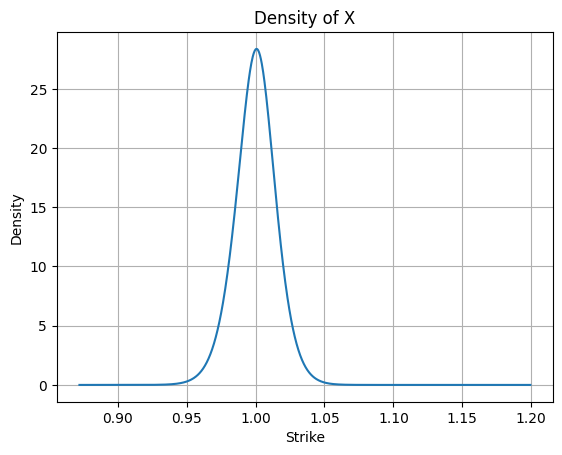

In [509]:
#integration of density
NumWeights = 1000
[u, w] = np.polynomial.legendre.leggauss(NumWeights)

# Integration bounds [0,10]
a = 0.8*X_forw
b = 1.1*X_forw

x = 0.5*(b-a)*u + 0.5*(a+b)
w_transformed = 0.5*(b-a)*w

# Compute density and integrate
density = SVIDensity(x, Xopt.x)
integral = np.sum(density * w_transformed)

print(f"Integral of SVI density: {integral:.6f}")

# Optional: Plot to verify
K_plot = np.linspace(a, b, 1000)
density_plot = SVIDensity(K_plot, Xopt.x)
plt.plot(K_plot, density_plot)
plt.title('Density of X')
plt.xlabel('Strike')
plt.ylabel('Density')
plt.grid(True)
plt.show()

Integral of SVI density: 1.000000


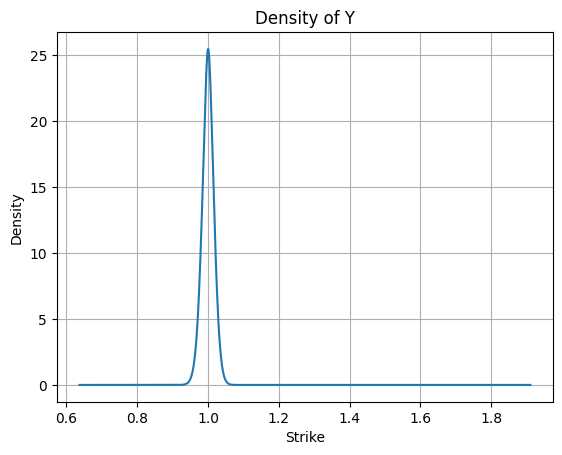

In [494]:
#integration of density
NumWeights = 1000
[u, w] = np.polynomial.legendre.leggauss(NumWeights)

# Integration bounds [0,10]
a = 0.5*Y_forw
b = 1.5*Y_forw

x = 0.5*(b-a)*u + 0.5*(a+b)
w_transformed = 0.5*(b-a)*w

# Compute density and integrate
density = SVIDensity(x, Yopt.x)
integral = np.sum(density * w_transformed)

print(f"Integral of SVI density: {integral:.6f}")

# Optional: Plot to verify
K_plot = np.linspace(a, b, 1000)
density_plot = SVIDensity(K_plot, Yopt.x)
plt.plot(K_plot, density_plot)
plt.title('Density of Y')
plt.xlabel('Strike')
plt.ylabel('Density')
plt.grid(True)
plt.show()

Integral of SVI density: 1.000000


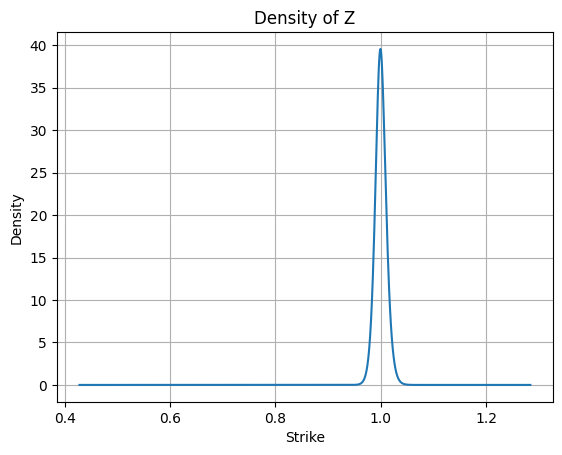

In [498]:

NumWeights = 1000
[u, w] = np.polynomial.legendre.leggauss(NumWeights)

a = 0.5*Z_forw
b = 1.5*Z_forw

x = 0.5*(b-a)*u + 0.5*(a+b)
w_transformed = 0.5*(b-a)*w


density = SVIDensity(x, Zopt.x)
integral = np.sum(density * w_transformed)

print(f"Integral of SVI density: {integral:.6f}")


K_plot = np.linspace(a, b, 1000)
density_plot = SVIDensity(K_plot, Zopt.x)
plt.plot(K_plot, density_plot)
plt.title('Density of Z')
plt.xlabel('Strike')
plt.ylabel('Density')
plt.grid(True)
plt.show()